In [1]:
from helpers import * 
from processor import *
from four_complete import *
from graph_checks import *
from four_complete_coordinates import *
from four_complete_locations import *
from four_complete_buffer import *


## start ordering... 

In [2]:
def create_next_graphs(G, subgraph_nodes):
    G_k_minus = nx.subgraph(G, subgraph_nodes) # nodes that are in the canonical order 
    G_diff = nx.subgraph(G, set(G.nodes).difference(set(G_k_minus.nodes)))
    return G_k_minus, G_diff

In [3]:
class ListHistoryTracker:
    def __init__(self, lst):
        self.history = [[]]  # Initialize with an empty list as the initial state
        self.current_state = lst[:]  # Make a copy of the initial list
        self.history.append(self.current_state)  # Append the initial state to history

    def append(self, item):
        self.current_state.append(item)
        self._update_history()

    def _update_history(self):
        self.history.append(self.current_state[:])

    def get_history(self):
        return self.history

## restart

In [4]:
bottom_data = get_saved_graph_data("BOTTOM")
side_data = get_saved_graph_data()

graph_data = side_data

In [5]:
f = FourComplete(graph_data)
f.get_boundary_cyle()
f.generate_dividing_indices()
f.divide_boundary_cycle()
f.ensure_no_cips()
f.paths

b = BoundaryCycle(copy.deepcopy(graph_data))
locs = FourCompleteLocations(copy.deepcopy(graph_data), f.boundary, f.paths, b.boundary_line_string)
locs.run()
locs.connect_outer_nodes()


ic| 'found cips - contains reverse'
ic| 'When assigning corner node directions, had to reshuffle'


In [6]:
def get_node_index(key):
    dict_key = get_key_by_value(locs.corner_node_dict, key, object=True)
    return locs.corner_node_dict[dict_key].index

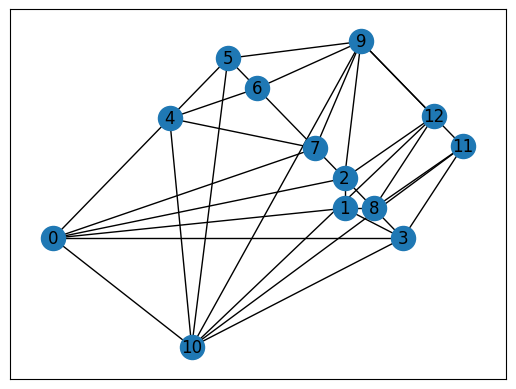

In [7]:
plot_planar(locs.G, locs.embed)


In [8]:
locs.corner_node_dict

{0: CornerNode({'neighbour_indices': [2, 7, 6, 5], 'name': 'north', 'index': 9, 'location': (0.4570016664553428, 0.5432085630070669), 'mean_location': None}),
 1: CornerNode({'neighbour_indices': [5, 4, 0, 3], 'name': 'south', 'index': 10, 'location': (-0.34381250856817736, -0.8620689655172413), 'mean_location': None}),
 2: CornerNode({'neighbour_indices': [3, 8], 'name': 'east', 'index': 11, 'location': (0.9397602871449979, 0.06044994231741163), 'mean_location': None}),
 3: CornerNode({'neighbour_indices': [8, 2], 'name': 'west', 'index': 12, 'location': (0.8018292526622394, 0.19838097680017025), 'mean_location': None})}

In [9]:
# set starting canonical 
G = copy.deepcopy(locs.G)
embed = copy.deepcopy(locs.embed)



G.nodes[get_node_index("south")]["canonical_order"] = 1
G.nodes[get_node_index("west")]["canonical_order"] = 2


# define the subgraph 
subgraph_nodes = []
subgraph_nodes.extend([get_node_index("south"), get_node_index("west")])
G_k_minus, G_diff = create_next_graphs(G, subgraph_nodes)

tracker = ListHistoryTracker(subgraph_nodes)


for order in range(2, len(G.nodes)):
    ic(subgraph_nodes)

    # find next node -> shared nb of past nodes which is in G_diff 
    v1 = subgraph_nodes[-2]
    v2 = subgraph_nodes[-1]
    candidate_nodes = [n for n in G.neighbors(v1) if n in G.neighbors(v2)]
    candidate_nodes_in_G_diff = list(set(candidate_nodes).intersection(set(G_diff.nodes)))
    ic((v1, v2), candidate_nodes, candidate_nodes_in_G_diff)

    # # check part 3 of refined canonical order theorem -> candidate node has two nbs in G_diff
    for node in candidate_nodes_in_G_diff:
        true_candidate_nodes = [] # TODO rename 

        neighbours = {n for n in G.neighbors(node)}

        if len(set(G_diff.nodes).intersection(neighbours)) >= 2:
            true_candidate_nodes.append(node)
        elif len(G_diff.nodes) <= 2: 
            true_candidate_nodes.append(node)

    ic(true_candidate_nodes)

        # if len(true_candidate_nodes) == 1:
        #     ic(true_candidate_nodes)
        # assert len(true_candidate_nodes) == 1, "candidate nodes are invalid!"

    next_node = true_candidate_nodes[0]

    G.nodes[next_node]["canonical_order"] = order

    subgraph_nodes.append(next_node)
    tracker.append(next_node)
   
    G_k_minus, G_diff = create_next_graphs(G, subgraph_nodes)




ic| subgraph_nodes: [10, 12]
ic| (v1, v2): (10, 12)
    candidate_nodes: [9]
    candidate_nodes_in_G_diff: [9]
ic| true_candidate_nodes: [9]
ic| subgraph_nodes: [10, 12, 9]
ic| (v1, v2): (12, 9)
    candidate_nodes: [2, 10]
    candidate_nodes_in_G_diff: [2]
ic| true_candidate_nodes: [2]
ic| subgraph_nodes: [10, 12, 9, 2]
ic| (v1, v2): (9, 2)
    candidate_nodes: [7, 12]
    candidate_nodes_in_G_diff: [7]
ic| true_candidate_nodes: [7]
ic| subgraph_nodes: [10, 12, 9, 2, 7]
ic| (v1, v2): (2, 7)
    candidate_nodes: [0, 9]
    candidate_nodes_in_G_diff: [0]
ic| true_candidate_nodes: [0]
ic| subgraph_nodes: [10, 12, 9, 2, 7, 0]
ic| (v1, v2): (7, 0)
    candidate_nodes: [2, 4]
    candidate_nodes_in_G_diff: [4]
ic| true_candidate_nodes: [4]
ic| subgraph_nodes: [10, 12, 9, 2, 7, 0, 4]
ic| (v1, v2): (0, 4)
    candidate_nodes: [7, 10]
    candidate_nodes_in_G_diff: []
ic| true_candidate_nodes: [4]
ic| subgraph_nodes: [10, 12, 9, 2, 7, 0, 4, 4]
ic| (v1, v2): (4, 4)
    candidate_nodes: [0, 5,

IndexError: list index out of range

In [ ]:
G.nodes.data()

NodeDataView({0: {'corner_or_interior': 'interior', 'canonical_order': 7}, 1: {'corner_or_interior': 'interior', 'canonical_order': 9}, 2: {'corner_or_interior': 'interior', 'canonical_order': 8}, 3: {'corner_or_interior': 'interior', 'canonical_order': 10}, 4: {'corner_or_interior': 'interior', 'canonical_order': 5}, 5: {'corner_or_interior': 'interior', 'canonical_order': 3}, 6: {'corner_or_interior': 'interior', 'canonical_order': 4}, 7: {'corner_or_interior': 'interior', 'canonical_order': 6}, 8: {'corner_or_interior': 'interior', 'canonical_order': 11}, 9: {'corner_or_interior': 'corner', 'canonical_order': 2}, 10: {'corner_or_interior': 'corner', 'canonical_order': 2}, 11: {'corner_or_interior': 'corner', 'canonical_order': 12}, 12: {'corner_or_interior': 'corner', 'canonical_order': 1}})

In [ ]:
history = tracker.get_history()
# history[2:]

embed_seq = []
for state in history[2:]:
    filtered_dict = {key: embed[key] for key in state if key in embed}
    embed_seq.append(filtered_dict)


ic| 'failed to get cycle'
ic| b.boundary_nodes: array([0, 1, 2], dtype=int32)
    b.boundary_edges: []
ic| 'failed to get cycle'
ic| b.boundary_nodes: array([1, 2, 3], dtype=int32)
    b.boundary_edges: 

[]
ic| 'failed to get cycle'
ic| b.boundary_nodes: array([1, 2, 3, 4], dtype=int32)
    b.boundary_edges: []


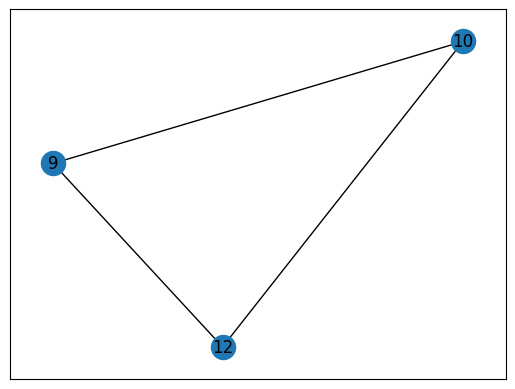

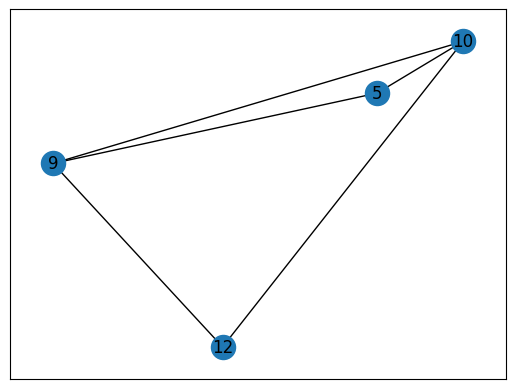

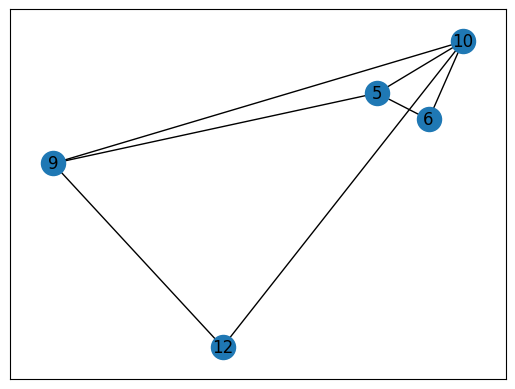

In [ ]:
for e in embed_seq[0:3]:
    plt.figure()
    subG = nx.subgraph(G_k_minus, e.keys())
    plot_planar(subG, e)
    if len(e.keys()) >=3:
        b = Boundaries(subG, e) # wghat about when G_k_minus smaller than embed?
        b.find_boundary_points()
        b.find_boundary_edges()
        try:
            b.find_cips()
            b.find_boundary_cycle()
            b.boundary_cycles
            ic(b.boundary_cycles)
        except:
            ic("failed to get cycle")
            ic(b.boundary_nodes, b.boundary_edges)